In [375]:

# Import Libraries
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Attention, Bidirectional, Dense, Dropout, Embedding, LayerNormalization, Conv1D, GlobalAveragePooling1D, Input, LSTM, MaxPooling1D, GlobalMaxPooling1D, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [376]:
df = pd.read_csv("../Datasets/Sarcasm_Headlines_Dataset_v2.csv")
df['is_sarcastic'].value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

(-0.5, 499.5, 499.5, -0.5)

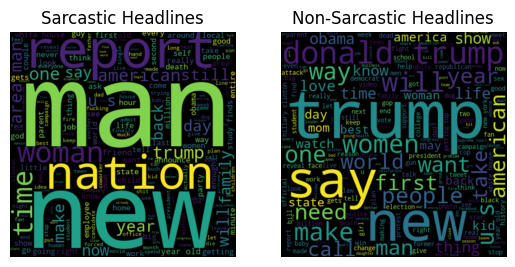

In [377]:
# Separating into sarcastic & non-sarcastic 
sarcastic = " ".join(df[df['is_sarcastic'] == 1]['headline'].astype(str))
non_sarcastic = " ".join(df[df['is_sarcastic'] == 0]['headline'].astype(str))

#print("sarcastic", sarcastic)
#print("non-sarcastic", non_sarcastic)

# Generate Word Cloud
wc_sarcastic = WordCloud(width = 500, height = 500, background_color = "black").generate(sarcastic)
wc_non_sarcastic = WordCloud(width = 500, height = 500, background_color = "black").generate(non_sarcastic)

# Plot Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(wc_sarcastic, interpolation="bilinear")
plt.title("Sarcastic Headlines")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wc_non_sarcastic, interpolation="bilinear")
plt.title("Non-Sarcastic Headlines")
plt.axis("off")

In [378]:
# Change to lowercase for all
df['cleaned_headline'] = df['headline'].apply(lambda x: x.lower())  

# Change words to integer, keep max of 20000 most frequent words
tokenizer = Tokenizer(num_words=20000)  
tokenizer.fit_on_texts(df['cleaned_headline'])
sequences = tokenizer.texts_to_sequences(df['cleaned_headline'])

# Pad with 0 if headlines less than 40 words for uniform length
MAX_HEADLINE_LENGTH = 30 
X = pad_sequences(sequences, maxlen = MAX_HEADLINE_LENGTH)

# 1 = sarcastic, 0 = non-sarcastic
y = df['is_sarcastic'].values

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [379]:
# Model: CNN + LSTM + Attention
DENSE_UNITS = 32
MAX_HEADLINE_LENGTH = 30 
VOCAB_SIZE = 20000 

# Model embedding
text_input = Input(shape=(MAX_HEADLINE_LENGTH,), dtype=tf.int32, name="text_input")
embedded_words = Embedding(input_dim=VOCAB_SIZE, 
                            output_dim = 100, 
                            input_length=MAX_HEADLINE_LENGTH)(text_input)

# CNN for feature extraction, can change the different values to experiment
cnn_layer_conv = Conv1D(filters = 32, kernel_size = 3, activation='relu', kernel_regularizer = regularizers.l2(0.001))(embedded_words)
cnn_layer = MaxPooling1D(pool_size = 2)(cnn_layer_conv)

# Bidirectional LSTM
lstm_input = cnn_layer
bilstm_layer = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2, recurrent_dropout = 0.1))(lstm_input)
bilstm_layer = LayerNormalization()(bilstm_layer)

# Attention to highlight impt parts of the sentence
attention_input = bilstm_layer
attention_layer = Attention()([attention_input, attention_input])
attention_layer =  LayerNormalization()(attention_layer)

# GlobalAveragePooling1D (idea from one of the website on kaggle)
pooling_input = attention_layer
pooling_layer_1 = GlobalAveragePooling1D()(pooling_input)
pooling_layer_2 = GlobalMaxPooling1D()(pooling_input)
pooling_layer = concatenate([pooling_layer_1, pooling_layer_2])

# Dense + Dropout + Normalization layer 
dense_layer = Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.001))(pooling_layer)
batch_normalization_layer = BatchNormalization()(dense_layer)
dropout_layer = Dropout(0.6)(batch_normalization_layer)

input = dropout_layer
output = Dense(1, activation = 'sigmoid')(input)

# Compile the model
CNN_LSTM_model = Model(inputs = text_input, outputs = output)
CNN_LSTM_model.compile(optimizer=Adam(learning_rate = 0.00005), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
CNN_LSTM_model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_95        │ (None, 30, 100)   │  2,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_93    │ (None, 30, 128)   │     84,480 │ embedding_95[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 128)   │        256 │ bidirectional_93… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_182 (Dense)   │ (None, 32)        │      8,224 │ concatenate_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_182[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_183 (Dense)   │ (None, 1)         │         33 │ dropout_91[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,093,121 (7.98 MB)

 Trainable params: 2,093,057 (7.98 MB)

 Non-trainable params: 64 (256.00 B)

In [380]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,    
    restore_best_weights=True
)

# Train
training = CNN_LSTM_model.fit(
    X_train,            
    y_train,
    batch_size=32,     
    epochs=15,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate
test_loss, test_accuracy = CNN_LSTM_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}%")
print(f"Test Loss: {test_loss:.4f}%")

# Predict
predictions = CNN_LSTM_model.predict(X_test)
y_pred_probs = CNN_LSTM_model.predict(X_test)
y_pred = (predictions > 0.5).astype("int32")

# F1-score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", macro_f1)





Epoch 1/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.5263 - loss: 1.0010 - val_accuracy: 0.6748 - val_loss: 0.6497
Epoch 2/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.6028 - loss: 0.7832 - val_accuracy: 0.7506 - val_loss: 0.5621
Epoch 3/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.6975 - loss: 0.6374 - val_accuracy: 0.7910 - val_loss: 0.5068
Epoch 4/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.7748 - loss: 0.5303 - val_accuracy: 0.8122 - val_loss: 0.4707
Epoch 5/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.8268 - loss: 0.4479 - val_accuracy: 0.8244 - val_loss: 0.4454
Epoch 6/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.8646 - loss: 0.3842 - val_accuracy: 0.8340 - val_loss: 0.4296
Epoch 7/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.8955 - loss: 0.3341 - val_accuracy: 0.8353 - val_loss: 0.4232
Epoch 8/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.9163 - loss: 0.2888 - 

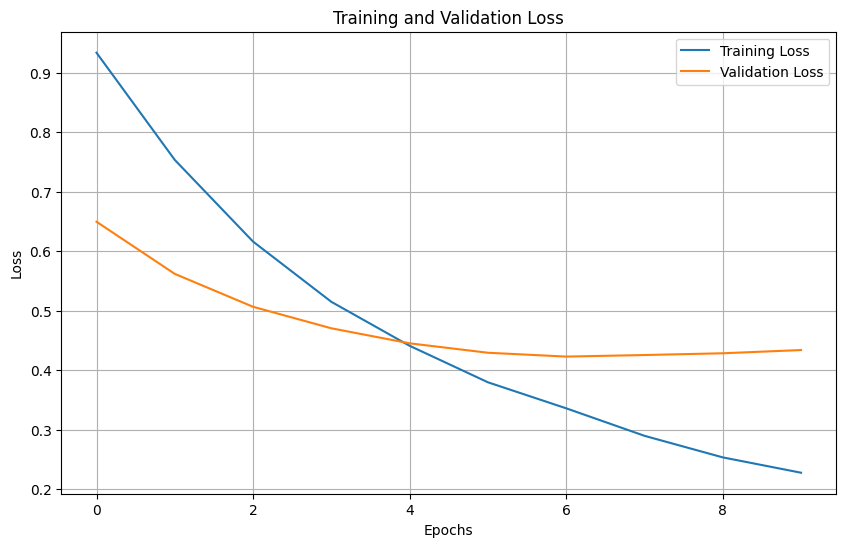

In [381]:
# Plot the training loss + validation loss on same graph
train_loss = training.history['loss']
val_loss = training.history['val_loss']

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()